https://probflow.readthedocs.io/en/stable/examples/time_to_event.html

In [1]:
# Imports
import probflow as pf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

2024-04-15 15:15:30.636719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class CensoredSurvivalModel(pf.ContinuousModel):

    def __init__(self, d):
        self.layer = pf.Dense(d)

    def __call__(self, x):
        return tfd.Exponential(tf.nn.softplus(self.layer(x)))

    def log_likelihood(self, x, y):
        """If y>=0, that's the time to the observed event.
        If y<0, it has not yet been observed after -y time!"""

        # Predicted distributions
        dist = self(x)

        # Likelihoods of observed time-to-events
        obs_ll = dist.log_prob(y)[y>=0]

        # Likelihoods of events not yet observed
        non_ll = dist.log_survival_function(-y)[y<0]

        # Return the sum of log likelihoods
        return tf.reduce_sum(obs_ll) + tf.reduce_sum(non_ll)

---

In [3]:
import pandas as pd
#import numpy as np

In [4]:
current_path='../data/our/'
output_path=current_path+'/GENE_2_counts_normalized.subject_unique.metadata.all.tsv'
df_exp=pd.read_csv(output_path,index_col=0,sep="\t",low_memory=False)
df_exp.head()

,sex,IDH,x1p19q,TERT,MGMT,Age,Survival_months,Vital_status,EGFR_re,CDKN2A_re,...,ENSG00000284649,ENSG00000284671,ENSG00000284680,ENSG00000284684,ENSG00000284691,ENSG00000284701,ENSG00000284723,"ENSG00000284733,ENSG00000284662",ENSG00000284741,NA
IID,,,,,,,,,,,,,,,,,,,,,
02-0047,male,WT,non-codel,NaN,Unmethylated,78,14.718995,1,Wildtype,Deleted,...,7.766,9.993,0,0.0,47.574,0,1,0.0,0.0,569.221
02-0055,female,WT,non-codel,NaN,Unmethylated,62,2.496972,1,Amplified,Wildtype,...,10.742,0.000,0,0.0,25.980,0,0,0.0,0.0,491.114
02-2485,male,WT,non-codel,Mutant,Unmethylated,53,15.441803,0,Amplified,Wildtype,...,5.379,0.000,0,0.0,69.000,0,1,0.0,0.0,717.150
02-2486,male,WT,non-codel,NaN,Unmethylated,64,16.197466,0,Amplified,Deleted,...,2.037,4.746,0,0.0,49.948,0,0,0.0,0.0,274.183
06-0125,female,WT,non-codel,Mutant,Methylated,63,47.573895,1,Amplified,Deleted,...,8.879,4.237,0,0.0,122.020,0,1,4.0,0.0,657.634


In [5]:
df_exp.drop(columns=['IDH','x1p19q','TERT','MGMT'],inplace=True)
df_exp.head()

,sex,Age,Survival_months,Vital_status,EGFR_re,CDKN2A_re,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,...,ENSG00000284649,ENSG00000284671,ENSG00000284680,ENSG00000284684,ENSG00000284691,ENSG00000284701,ENSG00000284723,"ENSG00000284733,ENSG00000284662",ENSG00000284741,NA
IID,,,,,,,,,,,,,,,,,,,,,
02-0047,male,78,14.718995,1,Wildtype,Deleted,2350.460,1.000,633.000,439.035,...,7.766,9.993,0,0.0,47.574,0,1,0.0,0.0,569.221
02-0055,female,62,2.496972,1,Amplified,Wildtype,2893.011,825.001,2382.838,569.035,...,10.742,0.000,0,0.0,25.980,0,0,0.0,0.0,491.114
02-2485,male,53,15.441803,0,Amplified,Wildtype,4940.435,5.000,1128.869,695.463,...,5.379,0.000,0,0.0,69.000,0,1,0.0,0.0,717.150
02-2486,male,64,16.197466,0,Amplified,Deleted,4338.707,7.000,1089.000,588.688,...,2.037,4.746,0,0.0,49.948,0,0,0.0,0.0,274.183
06-0125,female,63,47.573895,1,Amplified,Deleted,3621.526,6.000,1226.225,632.096,...,8.879,4.237,0,0.0,122.020,0,1,4.0,0.0,657.634


In [6]:
if 'sex' in df_exp.columns:
    df_exp['sex'].replace(to_replace={'female':0, 'male':1}, inplace=True)
if 'MGMT' in df_exp.columns:
    df_exp['MGMT'].replace(to_replace={'Unmethylated':0, 'Methylated':1}, inplace=True)
if 'EGFR_re' in df_exp.columns:
    df_exp['EGFR_re'].replace(to_replace={"Wildtype":0, "Amplified":1}, inplace=True)
if 'CDKN2A_re' in df_exp.columns:
    df_exp['CDKN2A_re'].replace(to_replace={"Wildtype":0, "Amplified":1, "Deleted":2}, inplace=True)

df_exp.head()

,sex,Age,Survival_months,Vital_status,EGFR_re,CDKN2A_re,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,...,ENSG00000284649,ENSG00000284671,ENSG00000284680,ENSG00000284684,ENSG00000284691,ENSG00000284701,ENSG00000284723,"ENSG00000284733,ENSG00000284662",ENSG00000284741,NA
IID,,,,,,,,,,,,,,,,,,,,,
02-0047,1,78,14.718995,1,0,2,2350.460,1.000,633.000,439.035,...,7.766,9.993,0,0.0,47.574,0,1,0.0,0.0,569.221
02-0055,0,62,2.496972,1,1,0,2893.011,825.001,2382.838,569.035,...,10.742,0.000,0,0.0,25.980,0,0,0.0,0.0,491.114
02-2485,1,53,15.441803,0,1,0,4940.435,5.000,1128.869,695.463,...,5.379,0.000,0,0.0,69.000,0,1,0.0,0.0,717.150
02-2486,1,64,16.197466,0,1,2,4338.707,7.000,1089.000,588.688,...,2.037,4.746,0,0.0,49.948,0,0,0.0,0.0,274.183
06-0125,0,63,47.573895,1,1,2,3621.526,6.000,1226.225,632.096,...,8.879,4.237,0,0.0,122.020,0,1,4.0,0.0,657.634


In [7]:
#df_exp.replace([np.inf, -np.inf], np.nan, inplace=True) 
X=df_exp.dropna(axis=0)  #,subset = ["Vital_status", "Survival_months"])
E=np.array(X.pop("Vital_status"))
Y=np.array(X.pop("Survival_months")).astype('float32')

More than 10 columns and predicting returns nans?
Doesn't matter if its 0:9 or 10:19

For some reason this isn't entirely true.

In [8]:
#X=X.iloc[:,0:4]
#X=X.iloc[:,0:11]

In [9]:
X.head()

,sex,Age,EGFR_re,CDKN2A_re,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,...,ENSG00000284649,ENSG00000284671,ENSG00000284680,ENSG00000284684,ENSG00000284691,ENSG00000284701,ENSG00000284723,"ENSG00000284733,ENSG00000284662",ENSG00000284741,NA
IID,,,,,,,,,,,,,,,,,,,,,
02-0047,1,78,0,2,2350.460,1.000,633.000,439.035,304.000,534.288,...,7.766,9.993,0,0.0,47.574,0,1,0.0,0.0,569.221
02-0055,0,62,1,0,2893.011,825.001,2382.838,569.035,497.997,1123.424,...,10.742,0.000,0,0.0,25.980,0,0,0.0,0.0,491.114
02-2485,1,53,1,0,4940.435,5.000,1128.869,695.463,743.572,503.997,...,5.379,0.000,0,0.0,69.000,0,1,0.0,0.0,717.150
02-2486,1,64,1,2,4338.707,7.000,1089.000,588.688,276.264,827.419,...,2.037,4.746,0,0.0,49.948,0,0,0.0,0.0,274.183
06-0125,0,63,1,2,3621.526,6.000,1226.225,632.096,602.204,250.999,...,8.879,4.237,0,0.0,122.020,0,1,4.0,0.0,657.634


In [10]:
len(X.columns)

55666

Vital_status=1 is deceased

In [11]:
E[0:5]

array([1, 1, 0, 0, 1])

In [12]:
Y[0:5]

array([14.718995 ,  2.4969723, 15.441803 , 16.197466 , 47.573895 ],
      dtype=float32)

In [13]:
newY = [Y[i] if E[i]==1 else -Y[i] for i in range(len(E))]
newY[0:5]

[14.718995, 2.4969723, -15.441803, -16.197466, 47.573895]

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
X=np.array(X).astype('float32')

In [16]:
X[0:4,0:4]

array([[ 1., 78.,  0.,  2.],
       [ 0., 62.,  1.,  0.],
       [ 1., 53.,  1.,  0.],
       [ 1., 64.,  1.,  2.]], dtype=float32)

In [17]:
scaler=StandardScaler().fit(X)

In [18]:
X=scaler.transform(X)

In [19]:
X[0:4,0:4]

array([[ 0.8136165 ,  1.2230637 , -3.4801023 ,  0.50589174],
       [-1.2290803 , -0.02108731,  0.28734788, -2.0895529 ],
       [ 0.8136165 , -0.72092235,  0.28734788, -2.0895529 ],
       [ 0.8136165 ,  0.13443157,  0.28734788,  0.50589174]],
      dtype=float32)

In [20]:
min(newY)

-16.197466

In [21]:
max(newY)

47.573895

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, newY, test_size=0.2)

In [24]:
x_train=np.array(x_train).astype('float32')

In [25]:
type(x_train)

numpy.ndarray

In [26]:
y_train=np.array(y_train).astype('float32')

In [27]:
type(y_train)

numpy.ndarray

In [28]:
x_train[0:4,0:4]

array([[ 0.8136165 , -0.02108731,  0.28734788,  0.50589174],
       [ 0.8136165 ,  0.05667214,  0.28734788,  0.50589174],
       [ 0.8136165 ,  0.912026  , -3.4801023 ,  0.50589174],
       [ 0.8136165 , -0.25436562, -3.4801023 , -2.0895529 ]],
      dtype=float32)

In [29]:
x_test[0:4,0:4]

array([[ 0.8136165 , -1.1097195 ,  0.28734788, -0.79183054],
       [-1.2290803 , -1.187479  ,  0.28734788,  0.50589174],
       [-1.2290803 ,  0.60098827,  0.28734788,  0.50589174],
       [-1.2290803 ,  0.98978543,  0.28734788, -2.0895529 ]],
      dtype=float32)

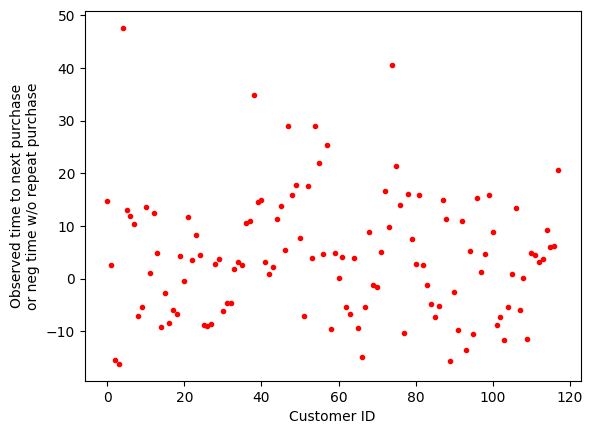

In [30]:
# Use all the data!
#x_train = X
#y_train = Y.copy()

# Neg. wait time w/ still no observation
#y_train[cix, 0] = t1[cix]-t_stop

# Plot it
plt.plot(newY, 'r.')
plt.xlabel('Customer ID')
plt.ylabel('Observed time to next purchase\n'
           'or neg time w/o repeat purchase')
plt.show()

In [31]:
X.shape[1]

55666

In [32]:
model3 = CensoredSurvivalModel(X.shape[1])

In [33]:
model3.fit(x_train, y_train, lr=0.02, epochs=1000) #, optimizer="RMSprop")

In [34]:
# Show model posteriors
#model3.posterior_plot(ci=0.9)

# True parameter values
#plt.subplot(2, 1, 1)
#plt.axvline(w[0], color='C0')
#plt.axvline(w[1], color='C1')
#plt.subplot(2, 1, 2)
#plt.axvline(b, color='C0')

In [35]:
# Make predictions with both models
#y_pred1 = model1.predict(x)
#y_pred2 = model2.predict(x)
y_pred3 = model3.predict(x_test)

In [36]:
y_pred3[0:5]

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

Text(0, 0.5, 'Predicted value')

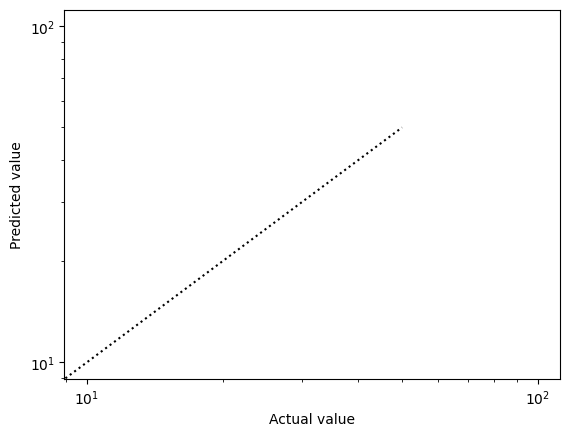

In [37]:
# Compare predictions from two models
#plt.plot(y, y_pred1, '.', label='Regular Model Predictions')
#plt.plot(y, y_pred2, '.', label='Censored Model Predictions')
#plt.plot([0.1, 100], [0.1, 100], 'k:', label='True')
plt.xscale('log')
plt.yscale('log')

#plt.legend(loc='upper left', shadow=True, fontsize='large')

#plt.plot(newY, y_pred3, '.', label='Model Predictions')

plt.plot(y_test, y_pred3, '.', label='Model Predictions')
plt.plot([-20, 50], [-20, 50], 'k:', label='True')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

Sometimes this will successfully run. 
Sometimes it won't.
Even when it does, it isn't terribly accurate.